In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from random import randrange


In [2]:
class Hull_White:
    ## k is mean reversion parameter, sig is the short term vol
    def __init__(self,bond_prices,k,sig,del_t,states):
        self.bond_prices = bond_prices
        self.k = k
        self.sig = sig
        self.del_t = del_t
        self.states = states
        self.rates = []

    ### used everytime we optimise on the tree
    def bond_PV(self,rates):
        PV = 0
        tree_prices = [[0]]
        for i in range(1,len(rates)):
            if len(rates[i-1]) < max(self.states) - min(self.states) + 1:
                tree_prices.append([0]*(len(tree_prices[i-1])+2))
            else:
                tree_prices.append([0]*(len(tree_prices[i-1])))
        tree_prices = list(reversed(tree_prices)) ## back to front
        rates = list(reversed(rates))
        for i in range(len(tree_prices[0])):
            tree_prices[0][i] = np.exp(-rates[0][i])

        for i in range(1,len(tree_prices)):
            mid = int(len(tree_prices[i])/2)
            for j in range(len(tree_prices[i])):
                pos = j - mid + 2
                q_probs = np.array(self.q_matrix[pos]).reshape(-1,1)
                if mid - j >= self.j_max:
                    prices = np.array(tree_prices[i-1][pos:pos+3]).reshape(-1,1)
                elif mid - j <= -self.j_max:
                    prices = np.array(tree_prices[i-1][pos-2:pos+1]).reshape(-1,1)
                else:
                    if len(tree_prices[i-1]) == 3:
                        prices = np.array(tree_prices[i-1]).reshape(-1,1)
                    else:
                        prices = np.array(tree_prices[i-1][pos-1:pos+2]).reshape(-1,1)
                
                q_expec = np.sum(prices*q_probs)
                tree_prices[i][j] = q_expec*np.exp(-rates[i][j])
                
        return tree_prices[-1][-1],tree_prices

    ### append next step rates
    def append_rates(self,ts_curr,m):
        if len(ts_curr[-1]) < max(self.states) - min(self.states) + 1: ### tree in growth stages, 
            ts_new = [0]*(len(ts_curr[-1])+2) ### create next layer in the tree
            for i in range(len(ts_curr[-1])):
                ts_new[i]   = ts_curr[-1][i] + m + self.del_r
                ts_new[i+1] = ts_curr[-1][i] + m 
                ts_new[i+2] = ts_curr[-1][i] + m - self.del_r
        else:
            ts_new = [0]*(len(ts_curr[-1]))
            ts_new = ts_curr[-1] + m
        return ts_curr + [ts_new]

    ### sets up risk neutral probability matrix
    def setup_rnp(self):
        k = self.k
        sig = self.sig
        del_t = self.del_t
        pos_moves = self.states
        M = np.exp(-k*del_t) - 1
        V = (sig**2/2*k)*(1 - np.exp(-2*k*del_t))
        self.del_r = np.sqrt(3*V) ### delta_r
        j_max = np.ceil(-0.184/M) ## to switch types
        
        q_matrix = np.zeros((len(pos_moves),3)) ### 5 start states,up,mid,down
        for i in range(len(pos_moves)):
            index = np.abs(pos_moves[i] - 2)
            if pos_moves[i] >= j_max: ### use type C
                q_matrix[index][2] = 1/6 + 0.5*(pos_moves[i]**2 * M**2*del_t**2 + pos_moves[i]*M*del_t)
                q_matrix[index][1] = -1/3 - pos_moves[i]**2 * M**2*del_t**2 - 2*pos_moves[i]*M*del_t
                q_matrix[index][0] = 7/6 + 0.5*(pos_moves[i]**2 * M**2*del_t**2 + 3*pos_moves[i]*M*del_t)
            elif pos_moves[i] <= -j_max:
                q_matrix[index][0] = 1/6 + 0.5*(pos_moves[i]**2 * M**2*del_t**2 - pos_moves[i]*M*del_t)
                q_matrix[index][1] = -1/3 - pos_moves[i]**2 * M**2*del_t**2 + 2*pos_moves[i]*M*del_t
                q_matrix[index][2] = 7/6 + 0.5*(pos_moves[i]**2 * M**2*del_t**2 - 3*pos_moves[i]*M*del_t)
            else:
                q_matrix[index][0] = 1/6 + 0.5*(pos_moves[i]**2 * M**2*del_t**2 + pos_moves[i]*M*del_t)
                q_matrix[index][1] = 2/3 - pos_moves[i]**2 * M**2*del_t**2 
                q_matrix[index][2] = 1/6 + 0.5*(pos_moves[i]**2 * M**2*del_t**2 - pos_moves[i]*M*del_t)
        
        self.q_matrix = q_matrix ### rnp matrix
        self.j_max = j_max ### the index where rate model gets switched up to mean revert
        
    def calibrate(self):
        bond_prices = self.bond_prices
        
        def func(m,ts_curr,targ_price):
            ts_optim = self.append_rates(ts_curr,m)
            expec_q,_ = self.bond_PV(ts_optim)
            return targ_price - expec_q
            
        calib_rates = [[np.log(1/bond_prices[0])]]
        guess = 0.005
        
        for i in range(1,len(bond_prices)):
            calib_m = fsolve(func,guess,args=(calib_rates,bond_prices[i]))
            calib_rates = self.append_rates(calib_rates,calib_m[0])
        self.rates = calib_rates
        return calib_rates
        
    def display_tree(self,tree=[]):
        if len(tree) == 0:
            tree = self.rates
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        
        max_depth = len(tree)
        max_width = len(tree[-1])
        node_radius = 0.5
    
        for depth, level in enumerate(tree):
            for index, value in enumerate(level):
                if isinstance(value, np.ndarray):
                    value = value.item()  # Ensure value is a scalar
                x = depth
                y = index - (len(level) - 1) / 2.0
                ax.add_patch(plt.Circle((x, y), node_radius, color='blue', alpha=0.2))
                ax.text(x, y, f"{float(value*100):.3f}%", horizontalalignment='center', verticalalignment='center')
        
        ax.set_xlim(-1, max_depth)
        ax.set_ylim(-(max_width - 1) / 2.0 - 1, (max_width - 1) / 2.0 + 1)
        ax.set_xticks(range(max_depth))
        ax.set_yticks([])
        ax.set_xticklabels([f"t={i}" for i in range(max_depth)])
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        plt.title("Hull-White Tree")
        plt.gca().invert_yaxis()
        plt.show()

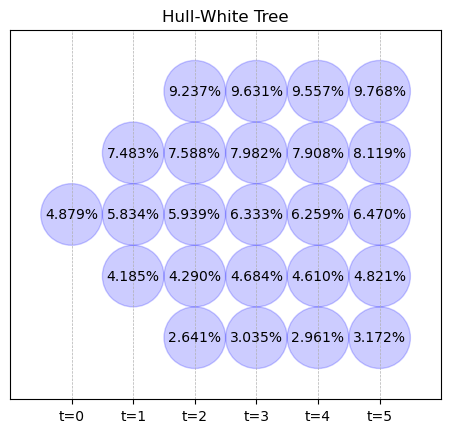

In [3]:
bond_yields = [0.05,0.055,0.057,0.059,0.06,0.061]
bond_prices = [1/(1+x)**(i+1) for (i,x) in enumerate(bond_yields)]

k = 0.1
vol = 0.01
sig = vol**0.5
states = [2,1,0,-1,-2]
del_t = 1
Trees_obj = Hull_White(bond_prices,k,sig,del_t,states)
Trees_obj.setup_rnp()
rates = Trees_obj.calibrate()
Trees_obj.display_tree()

### MBS

In [4]:
class prepay_MBS:
    def __init__(self,P,T,c,HW_tree,prepay_dict):
        self.P = P
        self.T = T
        self.c = c
        self.HW_tree = HW_tree
        self.prepay_dict = prepay_dict

    def get_fixed_coupon(self,P,c,t):
        return P*c/(1 - (1/(1+c))**t)
        
    def sim_rates_path(self,probs):
        rates = self.HW_tree.rates
        rate_path = [rates[0][0]] ### first step
        prev_node = 0
        for i in range(1,len(rates)):
            partition = probs[i]
            if partition < 1/3:
                if prev_node == 2:
                    curr_node = prev_node
                elif prev_node == -2:
                    curr_node = prev_node + 2
                else:
                    curr_node = prev_node + 1
            elif partition < 2/3:
                if prev_node == 2:
                    curr_node = prev_node - 1
                elif prev_node == -2:
                    curr_node = prev_node + 1
                else:
                    curr_node = prev_node
            else:
                if prev_node == 2:
                    curr_node = prev_node - 2
                elif prev_node == -2:
                    curr_node = prev_node
                else:
                    curr_node = prev_node - 1
            array_pos = int(len(rates[i]))/2 - curr_node
            rate_path.append(rates[i][int(array_pos)])
            prev_node = curr_node                             
        return rate_path
    
    def get_prepayment_rate(self,int_rate):
        r = self.HW_tree.rates[0][0]
        x_arr = [r - 0.02, r - 0.01, r - 0.005, r]
        y_arr = [0.17, 0.08, 0.05, 0.03]
        return np.interp(int_rate, x_arr, y_arr)

    def MBS_PV(self,rates):
         ### all calculations below are per unit of notional, values are scaled accordingly
        cashflows = [1.055]
        for i in range(self.T - 1,-1,-1):
            coupon_pay = self.get_fixed_coupon(1,self.c,self.T-i+1)
            rem_princ = 1 - (coupon_pay - self.c) ### the balance leftover
            prepay_rate = self.get_prepayment_rate(rates[i])
            prepay = rem_princ*prepay_rate
            princ_next = rem_princ - prepay
            if i != 0:
                cashflows.append(cashflows[-1]*princ_next*np.exp(-rates[i]) + coupon_pay + prepay)
            else:
                cashflows.append(cashflows[-1]*np.exp(-rates[i]))
        return self.P*cashflows[-1],cashflows

    def Monte_Carlo(self,sim_len = 1000,antithetic = False):
        sim_PV = []
        rates = self.HW_tree.rates
        for i in range(sim_len):
            probs = np.random.uniform(0,1,6)
            rate_samples = self.sim_rates_path(probs)
            PV,_ = self.MBS_PV(rate_samples)
            if antithetic:
                probs = 1 - probs
                rate_samples = self.sim_rates_path(probs)
                anti_PV,_ = self.MBS_PV(rate_samples)
                PV = 0.5*(PV + anti_PV)
            sim_PV.append(PV)
        print("Estimation standard deviation: ", np.std(np.array(sim_PV))/np.sqrt(len(sim_PV)))
        print("Estimation Average: ", np.mean(np.array(sim_PV)))
        return sim_PV

    def Tree_eval(self):
        rates = self.HW_tree.rates
        jmax = self.HW_tree.j_max
        c = self.c
        prepay_tree = [self.get_prepayment_rate(rate_tree) for rate_tree in rates]
        q_matrix = self.HW_tree.q_matrix
        ### all calculations below are per unit of notional, values are scaled accordingly
        cashflow_tree = [np.array([1+c]*len(rates[-1]))] ### cashflow init
        print(self.T-1)
        for i in range(self.T-1,-1,-1):
            mid = int(len(rates[i])/2)
            coupon_i  = self.get_fixed_coupon(1,c,self.T-i+1) ### the constant coupon payment at "start" of time i(same for all nodes)
            rem_princ = 1 - (coupon_i - c) ### the balance leftover
            cf_i = np.zeros(len(rates[i])) ### cf/notional at time i
            for j in range(len(cf_i)):
                pos = j - mid + 2
                q_probs = np.array(q_matrix[pos]).reshape(-1,1)
                if mid - j >= jmax:
                    prices = np.array(cashflow_tree[self.T-i-1][pos:pos+3]).reshape(-1,1)
                elif mid - j <= -jmax:
                    prices = np.array(cashflow_tree[self.T-i-1][pos-2:pos+1]).reshape(-1,1)
                else:
                    if len(cashflow_tree[-1]) == 3:
                        prices = np.array(cashflow_tree[self.T-i-1]).reshape(-1,1)
                    else:
                        prices = np.array(cashflow_tree[self.T-i-1][pos-1:pos+2]).reshape(-1,1)
                
                pre_pay = prepay_tree[i][j]*rem_princ
                princ_next = rem_princ - pre_pay ### the amount of principal carrying forward
                q_expec = np.sum(prices*q_probs)
                if i != 0:
                    cf_i[j] = q_expec*princ_next*np.exp(-rates[i][j]) + pre_pay + coupon_i
                else:
                    cf_i[j] = q_expec*np.exp(-rates[i][j])
            cashflow_tree.append(cf_i)
        return cashflow_tree                

coupon_rate = 5.5e-2
principal = 1e6
T = 6
cash_flows = []
P = principal
prepay_dict = {0:0.03,-50e-4:0.05,-100e-4:0.08,-200e-4:0.17}
MBS_obj = prepay_MBS(P,T,coupon_rate,Trees_obj,prepay_dict)
print("Barebones MC")
monte_sim = MBS_obj.Monte_Carlo()
print("Antithetic MC")
antithetic_sim = MBS_obj.Monte_Carlo(sim_len=500,antithetic=True)

Barebones MC
Estimation standard deviation:  905.8931155654467
Estimation Average:  988956.4025484513
Antithetic MC
Estimation standard deviation:  22.1879659704947
Estimation Average:  989677.2283247832


### Antithetic generation
The paths themselves were generated using sampling from $U(0,1)$ by splitting it to three equal intervals. As for antithetic paths, we just take the sampled point in $U(0,1)$, calculate $1-sample$ and then use it to identify which states(up,middle,down) this path takes. We can clearly see that the standard deviation reduces significantly when using antithetic paths compared to normal paths

### Using a recombining tree, notice that value/notional at T=6 is constant in all states implying that recombining property exists for all intermediate levels

In [5]:
MBS_value = MBS_obj.Tree_eval()
final_value = MBS_value[-1][0]*P
print(f"MBS Valuation using the tree is {final_value}")

5
MBS Valuation using the tree is 989811.8549122005
